In [11]:
from google.colab import drive
drive.mount('/content/drive')
import os
import cv2
import numpy as np
import random
import psutil

def get_ram_usage():
    process = psutil.Process(os.getpid())
    mem = process.memory_info().rss / (1024 ** 3)  # GB
    print(f"Current RAM usage: {mem:.2f} GB")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import os
import cv2
import numpy as np
import random

# The generator
def patch_batch_generator(file_list, image_dir, density_dir,
                           input_size=(768, 1024), patch_size=512, batch_size=8, output_size=64):
    h_img, w_img = input_size

    while True:
        image_batch = []
        density_batch = []

        while len(image_batch) < batch_size:
            # Randomly pick one image
            image_file = random.choice(file_list)

            # Load image
            image_path = os.path.join(image_dir, image_file)
            density_path = os.path.join(density_dir, image_file.replace('.jpg', '.npy'))

            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (w_img, h_img))
            image_norm = image / 255.0

            # Load density map
            density = np.load(density_path)
            old_h, old_w = density.shape

            # Resize density map to match image size
            density_resized = cv2.resize(density, (w_img, h_img), interpolation=cv2.INTER_LINEAR)
            scaling_factor = (old_h * old_w) / (h_img * w_img)
            density_resized = density_resized * scaling_factor

            # Extract random patch from image and density (both 512x512)
            x_max = w_img - patch_size
            y_max = h_img - patch_size
            x = random.randint(0, x_max)
            y = random.randint(0, y_max)

            image_patch = image_norm[y:y+patch_size, x:x+patch_size, :]
            density_patch = density_resized[y:y+patch_size, x:x+patch_size]

            # Resize density patch to output size (e.g., 64x64)
            density_patch_resized = cv2.resize(density_patch, (output_size, output_size), interpolation=cv2.INTER_LINEAR)
            # Adjust density sum after resizing
            density_patch_resized *= (patch_size * patch_size) / (output_size * output_size)
            density_patch_resized = np.expand_dims(density_patch_resized, axis=-1)

            image_batch.append(image_patch)
            density_batch.append(density_patch_resized)

        yield np.array(image_batch), np.array(density_batch)

# Directory setup
image_dir= '/content/drive/MyDrive/images'
density_dir = '/content/drive/MyDrive/train_data_sigma_9/'

# Prepare file list
image_files = os.listdir(image_dir)
image_files = [f for f in image_files if f.endswith('.jpg')]

from sklearn.model_selection import train_test_split
train_files, val_files = train_test_split(image_files, test_size=0.1, random_state=42)

# Create generators with batch_size = 8 (you can change)
train_gen = patch_batch_generator(train_files, image_dir, density_dir, batch_size=8)
val_gen = patch_batch_generator(val_files, image_dir, density_dir, batch_size=8)

In [13]:
# import tensorflow as tf
# from tensorflow.keras import layers, initializers
# from keras.models import Model
# from keras.layers import *
# from tensorflow.keras.optimizers import Adam

# class CBAMLayer(tf.keras.layers.Layer):
#     def __init__(self, reduction_ratio=8, **kwargs):
#         super(CBAMLayer, self).__init__(**kwargs)
#         self.reduction_ratio = reduction_ratio

#     def build(self, input_shape):
#         self.channel = input_shape[-1]
#         self.shared_dense_one = tf.keras.layers.Dense(self.channel // self.reduction_ratio,
#                                                       activation='relu')
#         self.shared_dense_two = tf.keras.layers.Dense(self.channel)

#         self.conv_spatial = tf.keras.layers.Conv2D(filters=1,
#                                                    kernel_size=7,
#                                                    padding='same',
#                                                    activation='sigmoid')

#     def call(self, inputs):
#         # ----- Channel Attention -----
#         avg_pool = tf.reduce_mean(inputs, axis=[1, 2], keepdims=True)
#         max_pool = tf.reduce_max(inputs, axis=[1, 2], keepdims=True)

#         avg_out = self.shared_dense_two(self.shared_dense_one(avg_pool))
#         max_out = self.shared_dense_two(self.shared_dense_one(max_pool))
#         scale = tf.nn.sigmoid(avg_out + max_out)
#         x = inputs * scale

#         # ----- Spatial Attention -----
#         avg_pool = tf.reduce_mean(x, axis=-1, keepdims=True)
#         max_pool = tf.reduce_max(x, axis=-1, keepdims=True)
#         concat = tf.concat([avg_pool, max_pool], axis=-1)
#         scale = self.conv_spatial(concat)
#         x = x * scale
#         return x

# Model_Input=Input(shape=(512,512,3))
# from keras.applications.vgg16 import VGG16

# base_model = VGG16(weights='imagenet',
#                   include_top=False,
#                   input_shape=(512, 512,3))

# conv_base = Model(inputs=base_model.input, outputs=base_model.get_layer('block4_conv3').output)

# conv_base.summary()

# x = conv_base(Model_Input)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 512, 512, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 512, 512, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 256, 256, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 256, 256, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 128, 128, 256)  │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 128, 128, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 128, 128, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 64, 64, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 64, 64, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 64, 64, 512)    │     2,359,808 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,635,264 (29.13 MB)

 Trainable params: 7,635,264 (29.13 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
p1 = CBAMLayer()(x)
a1=Conv2D(512,5,padding='same',activation='relu')(p1) # skip connections
a2=Conv2D(512,5,padding='same',activation='relu')(a1)
a3=Conv2D(256,3,padding='same',activation='relu')(a2)
a4=Conv2D(128,3,padding='same',activation='relu')(a3)
a5=Conv2D(64,3,padding='same',activation='relu')(a4)

b1=Conv2D(512,3,padding='same',activation='relu', dilation_rate=2)(p1)
b2=Conv2D(256,3,padding='same',activation='relu',  dilation_rate=2)(b1)
b3=Conv2D(128,3,padding='same',activation='relu',  dilation_rate=4)(b2)
b4=Conv2D(64,3,padding='same',activation='relu', dilation_rate=4)(b3)

# c1=Conv2D(512,5,padding='same',activation='relu')(p1)
# c2=Conv2D(256,3,padding='same',activation='relu')(c1)
# c3=Conv2D(128,3,padding='same',activation='relu')(c2)
# c4=Conv2D(64,1,padding='same',activation='relu')(c3)

merged_ouput=concatenate([a5,b4])
d1=CBAMLayer()(merged_ouput)
e1=Conv2D(1,1)(d1)

model=Model(inputs=Model_Input,outputs=e1)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_2        │ (None, 64, 64,    │  7,635,264 │ input_layer_2[0]… │
│ (Functional)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cbam_layer_2        │ (None, 64, 64,    │     66,211 │ functional_2[0][… │
│ (CBAMLayer)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 64, 64,    │  6,554,112 │ cbam_layer_2[0][… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 64, 64,    │  6,554,112 │ conv2d_15[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 64, 64,    │  2,359,808 │ cbam_layer_2[0][… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 64, 64,    │  1,179,904 │ conv2d_16[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 64, 64,    │  1,179,904 │ conv2d_20[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 64, 64,    │    295,040 │ conv2d_17[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 64, 64,    │    295,040 │ conv2d_21[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 64, 64,    │     73,792 │ conv2d_18[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │     73,792 │ conv2d_22[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 64, 64,    │          0 │ conv2d_19[0][0],  │
│ (Concatenate)       │ 128)              │            │ conv2d_23[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cbam_layer_3        │ (None, 64, 64,    │      4,339 │ concatenate_1[0]… │
│ (CBAMLayer)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 64, 64, 1) │        129 │ cbam_layer_3[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 26,271,447 (100.22 MB)

 Trainable params: 26,271,447 (100.22 MB)

 Non-trainable params: 0 (0.00 B)

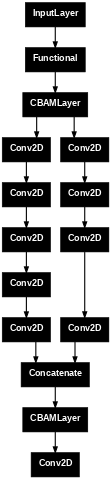

In [15]:
from keras.utils import plot_model
plot_model(model,dpi=40)

In [16]:
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.metrics import MeanAbsoluteError

# # Compile model with Adam optimizer and MSE loss + MAE metric
# model.compile(
#     optimizer=Adam(learning_rate=1e-5),
#     loss='mse',
#     metrics=[MeanAbsoluteError()]
# )

# # EarlyStopping on training loss (lower is better)
# early_stopping = EarlyStopping(
#     monitor='val_loss',
#     patience=10,
#     verbose=1,
#     mode='min'
# )

# # Reduce learning rate on plateau (training loss)
# reduce_lr = ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.5,
#     patience=3,
#     verbose=1,
#     min_lr=1e-7
# )

# # Train the model using generators
# history = model.fit(
#     train_gen,
#     validation_data=val_gen,
#     steps_per_epoch=100,
#     validation_steps=10,
#     epochs=20,
#     callbacks=[early_stopping, reduce_lr]
# )

In [17]:
# # Save the model in HDF5 format
# model.save('new_model7.keras')

# # Download the model file to your laptop
# from google.colab import files
# files.download('new_model7.keras')

# from google.colab import files
# uploaded = files.upload()

In [18]:
# from tensorflow.keras.models import load_model
# model = load_model('new_model7.keras',custom_objects={"CBAMLayer": CBAMLayer})

In [24]:
import tensorflow as tf
from tensorflow.keras import layers
from keras.models import Model
from keras.layers import Input, Conv2D, concatenate
from keras.applications.vgg16 import VGG16

# Your custom CBAM Layer remains unchanged
class CBAMLayer(tf.keras.layers.Layer):
    def __init__(self, reduction_ratio=8, **kwargs):
        super(CBAMLayer, self).__init__(**kwargs)
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        self.channel = input_shape[-1]
        self.shared_dense_one = tf.keras.layers.Dense(self.channel // self.reduction_ratio,
                                                      activation='relu')
        self.shared_dense_two = tf.keras.layers.Dense(self.channel)
        self.conv_spatial = tf.keras.layers.Conv2D(filters=1, kernel_size=7, padding='same', activation='sigmoid')

    def call(self, inputs):
        avg_pool = tf.reduce_mean(inputs, axis=[1, 2], keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=[1, 2], keepdims=True)
        avg_out = self.shared_dense_two(self.shared_dense_one(avg_pool))
        max_out = self.shared_dense_two(self.shared_dense_one(max_pool))
        scale = tf.nn.sigmoid(avg_out + max_out)
        x = inputs * scale
        avg_pool = tf.reduce_mean(x, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(x, axis=-1, keepdims=True)
        concat = tf.concat([avg_pool, max_pool], axis=-1)
        scale = self.conv_spatial(concat)
        x = x * scale
        return x

# ✅ Rebuild with flexible input shape
Model_Input = Input(shape=(None, None, 3))

# Load pretrained VGG16 base up to block4_conv3
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(None, None, 3))
conv_base = Model(inputs=base_model.input, outputs=base_model.get_layer('block4_conv3').output)

# Forward pass
x = conv_base(Model_Input)
p1 = CBAMLayer()(x)

a1 = Conv2D(512, 5, padding='same', activation='relu')(p1)
a2 = Conv2D(512, 5, padding='same', activation='relu')(a1)
a3 = Conv2D(256, 3, padding='same', activation='relu')(a2)
a4 = Conv2D(128, 3, padding='same', activation='relu')(a3)
a5 = Conv2D(64, 3, padding='same', activation='relu')(a4)

b1 = Conv2D(512, 3, padding='same', activation='relu', dilation_rate=2)(p1)
b2 = Conv2D(256, 3, padding='same', activation='relu', dilation_rate=2)(b1)
b3 = Conv2D(128, 3, padding='same', activation='relu', dilation_rate=4)(b2)
b4 = Conv2D(64, 3, padding='same', activation='relu', dilation_rate=4)(b3)

merged_output = concatenate([a5, b4])
d1 = CBAMLayer()(merged_output)
e1 = Conv2D(1, 1)(d1)

model = Model(inputs=Model_Input, outputs=e1)

# ✅ Now load weights only (not full model)
model.load_weights('new_model7.keras')
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_4        │ (None, None,      │  7,635,264 │ input_layer_4[0]… │
│ (Functional)        │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cbam_layer_4        │ (None, None,      │     66,211 │ functional_4[0][… │
│ (CBAMLayer)         │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, None,      │  6,554,112 │ cbam_layer_4[0][… │
│                     │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, None,      │  6,554,112 │ conv2d_27[0][0]   │
│                     │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, None,      │  2,359,808 │ cbam_layer_4[0][… │
│                     │ None, 512)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, None,      │  1,179,904 │ conv2d_28[0][0]   │
│                     │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, None,      │  1,179,904 │ conv2d_32[0][0]   │
│                     │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, None,      │    295,040 │ conv2d_29[0][0]   │
│                     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, None,      │    295,040 │ conv2d_33[0][0]   │
│                     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, None,      │     73,792 │ conv2d_30[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, None,      │     73,792 │ conv2d_34[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, None,      │          0 │ conv2d_31[0][0],  │
│ (Concatenate)       │ None, 128)        │            │ conv2d_35[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cbam_layer_5        │ (None, None,      │      4,339 │ concatenate_2[0]… │
│ (CBAMLayer)         │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, None,      │        129 │ cbam_layer_5[0][… │
│                     │ None, 1)          │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 26,271,447 (100.22 MB)

 Trainable params: 26,271,447 (100.22 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# # Build new model
# inputs = keras.Input(shape=(None, None, 3))
# x = YourFullyConvolutionalArchitecture(inputs)
# new_model = keras.Model(inputs, x)

# # Load weights from saved model (if saved as weights, not full model)
# new_model.load_weights('your_weights.h5')

In [25]:
import os
import scipy.io
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_ground_truth(mat_file):
    data = scipy.io.loadmat(mat_file)
    points = data['image_info'][0,0][0,0][0]
    return points

def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (768,1024))
    image = image / 255.0
    image = np.expand_dims(image, axis=0)
    return image

# Set paths
test_image_dir = '/content/drive/MyDrive/test/images'
test_gt_dir = '/content/drive/MyDrive/test/ground_truth'
test_files = os.listdir(test_image_dir)

In [26]:
# Start evaluation
total_absolute_error = 0
total_samples = 0

for file in test_files:
    image_path = os.path.join(test_image_dir, file)
    gt_path = os.path.join(test_gt_dir, "GT_" + file.replace(".jpg", ".mat"))

    # Load and preprocess
    test_image = preprocess_image(image_path)

    # Predict
    predicted_density = model.predict(test_image)
    predicted_density = np.squeeze(predicted_density)
    predicted_count = predicted_density.sum()

    # Ground truth count
    points = load_ground_truth(gt_path)
    gt_count = len(points)

    # Compare
    error = abs(predicted_count - gt_count)
    total_absolute_error += error
    total_samples += 1

    print(f"Image: {file}")
    print(f"Predicted Count: {predicted_count:.2f}")
    print(f"Ground Truth Count: {gt_count}")
    print(f"Absolute Error: {error:.2f}\n")

# Compute MAE (Mean Absolute Error)
mae = total_absolute_error / total_samples
print(f"Mean Absolute Error on test set: {mae:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
Image: IMG_182.jpg
Predicted Count: 134.99
Ground Truth Count: 253
Absolute Error: 118.01

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Image: IMG_126.jpg
Predicted Count: 33.46
Ground Truth Count: 58
Absolute Error: 24.54

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
Image: IMG_266.jpg
Predicted Count: 44.83
Ground Truth Count: 59
Absolute Error: 14.17

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
Image: IMG_185.jpg
Predicted Count: 66.94
Ground Truth Count: 106
Absolute Error: 39.06

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Image: IMG_236.jpg
Predicted Count: 134.18
Ground Truth Count: 196
Absolute Error: 61.82

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Image: IMG_24.jpg
Predicted Count: 51.49
Ground Truth Count: 79
Absolute Error: 27.51

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Image: IMG_120.jpg
Predicted Count: 57.41
Ground Truth Count: 73
Absolute Error: 15.59

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Image: IMG_21.jpg
Predicted Count: 71.22
Ground Truth Count: 89
Absolute Er

In [21]:
# import os
# import numpy as np
# import cv2
# from scipy.io import loadmat

# # Normalize and load image
# def preprocess_image(image_path):
#     image = cv2.imread(image_path)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     return image / 255.0

# # Load .mat GT points (ShanghaiTech format or annPoints)
# def load_ground_truth(mat_path):
#     mat = loadmat(mat_path)
#     if 'image_info' in mat:
#         points = mat['image_info'][0][0][0][0][0]
#     elif 'annPoints' in mat:
#         points = mat['annPoints']
#     else:
#         raise ValueError(f"Unknown GT format in: {mat_path}")
#     return points  # shape: (N, 2)

# # Extract N random non-overlapping patches from image and filter GT inside them
# def get_random_patches_with_gt(image, points, patch_size=512, num_patches=4):
#     h, w = image.shape[:2]
#     patches = []

#     for _ in range(num_patches):
#         if h < patch_size or w < patch_size:
#             raise ValueError("Image smaller than patch size.")

#         x = np.random.randint(0, w - patch_size + 1)
#         y = np.random.randint(0, h - patch_size + 1)

#         patch = image[y:y+patch_size, x:x+patch_size, :]

#         # Get GT points inside patch
#         mask = (
#             (points[:, 0] >= x) & (points[:, 0] < x + patch_size) &
#             (points[:, 1] >= y) & (points[:, 1] < y + patch_size)
#         )
#         patch_points = points[mask] - np.array([x, y])  # Shift to patch coordinates

#         patches.append((patch, patch_points))

#     return patches  # List of (patch_img, patch_gt_points)


In [23]:

# # === Begin Evaluation ===
# total_absolute_error = 0
# total_samples = 0
# patch_size = 512

# for file in test_files:
#     image_path = os.path.join(test_image_dir, file)
#     gt_path = os.path.join(test_gt_dir, "GT_" + file.replace(".jpg", ".mat"))

#     # Load image and GT
#     image = preprocess_image(image_path)
#     points = load_ground_truth(gt_path)

#     # Get 4 random patches with corresponding GT points
#     try:
#         patches_with_gt = get_random_patches_with_gt(image, points, patch_size=patch_size, num_patches=4)
#     except ValueError as ve:
#         print(f"Skipping {file}: {ve}")
#         continue

#     image_absolute_error = 0  # accumulate error for 4 patches of this image

#     for patch, patch_gt in patches_with_gt:
#         patch_input = np.expand_dims(patch, axis=0)
#         pred_density = model.predict(patch_input, verbose=0)
#         pred_density = np.squeeze(pred_density)
#         pred_count = pred_density.sum()
#         gt_count = len(patch_gt)

#         error = abs(pred_count - gt_count)
#         image_absolute_error += error

#     # Compute average error for this image (across 4 patches)
#     avg_error_per_image = image_absolute_error / 4
#     print(f"Image: {file} | Avg Loss (4 patches): {avg_error_per_image:.2f}")

#     total_absolute_error += image_absolute_error
#     total_samples += 4  # since 4 patches processed

# # Final MAE across entire dataset
# mae = total_absolute_error / total_samples
# print(f"Final Mean Absolute Error over all patches: {mae:.2f}")


Image: IMG_182.jpg | Avg Loss (4 patches): 257.79
Image: IMG_126.jpg | Avg Loss (4 patches): 257.49


KeyboardInterrupt: 